# 자연어 토큰화 방법에 따른 모델 성능 비교 예제

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 
토큰화 기법에 따른 모델의 성능을 비교하였다. 토큰화 기법은 '공백 기반 토큰화', '형태소 기반 토큰화', 'SentencePiece 기반 토큰화'로 구분하여 데이터셋에 대한 토큰화를 진행하였다. 네이버 영화 리뷰 문장 데이터를 이용한 긍, 부정 분석 모델을 생성하였으며, 각 토큰화 기법에 따라 생성한 학습 데이터를 이용하여 모델을 학습 하여 비교 분석을 시행하였다. 데이터셋은 학습 데이터 150,000개, 테스트 데이터 50,000개로 이루어져 있으며, 결측치, 중복 데이터를 제거한 후, 최소 10개 단어, 최대 120개 단어로 이루어진 문장만을 학습 데이터로 이용하였다. 모델은 1D Convolution 레이어를 기반으로 하였으며, 옵티마이저는 Adam을 이용하고 총 10회 학습 하였다. 그 결과 '공백 기준 토큰화 기법'의 경우, 단어사전 크기는 308,477로 가장 큰 편이었으며, 1 Epoch 당 소요 시간은 131초로 가장 많은 시간이 소요되었다. 테스트 데이터에 대한 손실값은 0.269, 정확도는 0.954로 가장 좋지 않은 성능을 제시하였다. '형태소 기준 토큰화 기법'의 경우, 단어사전 크기는 49,060으로 중간 크기였으며, 1 Epoch 당 학습 소요 시간 28초로 중간에 해당하였다. 테스트 데이터에 대한 손실값은 0.163, 정확도는 0.962로 가장 좋은 성능을 제시하였다. 'SentencePiece 기준 토큰화 기법'의 경우, 단어사전의 크기가 8,000개로 가장 작았으며, 1 Epoch 당 학습 소요 시간 18초로 가장 빠르게 학습이 이루어졌다. 테스트 데이터에 대한 손실값은 0.179, 정확도는 0.960으로 '형태소 기준 토큰화 기법'과 비교하였을 때, 큰 차이가 없는 성능을 제시하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 토큰화 기법에 따른 모델 성능을 비교하고자 합니다. 이를 위해 네이버 영화 리뷰 문장 데이터셋을 이용하며, 문장을 바탕으로 긍, 부정 분석 모델을 생성하여 진행 합니다. 토큰화 기법은 '공백 기반', '형태소 기반', 'SentencePiece 기반'으로 구분하고 각 기법에 따른 모델의 성능을 비교할 것입니다. 다음은 본 예제의 진행 순서를 제시한 것입니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 토크나이저 별 토큰화_
>
> _4. 모델 생성_
>
> _5. 모델 학습 및 평가_


***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 2015년 박은정 박사의 『Naver sentiment movie corpus v1.0』에서 제공된 자연어 데이터셋으로 영화에 대한 140자 이내의 리뷰평과 해당 리뷰의 긍, 부정을 의미하는 라벨, 작성 id 속성으로 이루어져 있습니다. train 데이터 150,000개, test 데이터 50,000개이며, 긍, 부정의 비율은 동일합니다. 분석 결과, 학습 데이터의 최대 문장 길이는 최대 146개, 평균 35개의 단어로 이루어져 있으며, 테스트 데이터의 최대 문장 길이는 최대 144개, 평균 35개의 단어로 이루어져 있음을 확인하였습니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리를 호출합니다.
***

In [1]:
import os   #디렉토리 관리
import numpy as np   #행렬 연산
import pandas as pd   #데이터 프레임
import matplotlib.pyplot as plt   #데이터 시각화
from sklearn.model_selection import train_test_split

import tensorflow as tf   #신경망
from tensorflow import keras   #신경망

from konlpy.tag import Mecab   #Mecab
import sentencepiece as spm   #sentencePiece

<br>

#### 데이터셋 불러오기
***
+ 예제에 사용되는 학습 데이터를 불러옵니다.


+ 데이터셋은 박은정 박사가 2015년 8월에 발표한 『Naver sentiment movie corpus v1.0』에서 제시된 데이터셋 입니다.
***

In [2]:
train_data = pd.read_table("./dataset/ratings_train.txt")
test_data = pd.read_table("./dataset/ratings_test.txt")

display(train_data.sample(5))
display(test_data.sample(5))

,id,document,label
141269,7442381,예측 가능한 전개와 뻔한 반전을 몇몇 진부한 공포 효과로는 극복할 수 없다. 얼굴을...,0
146810,9886069,이런 영화좀 만들지 말길..,0
52891,10137822,밑에 좋은 점수들은 다 가짜입니다. 진짜 재미없음.,0
79658,6562465,아휴 조기종영이라니요ㅜㅜ 왜그러신데요 그럼 청담동살아요 투 원합니다!,1
59570,7956442,이런 쓰레기가 ...,0


,id,document,label
33764,8569826,누가봐도 보이는 투명한 영화,0
30725,9974766,되게 재미있게 봤었다는ㅎㅎ,1
8253,2160035,액션영화보고 눈물날뻔한거는 처음이네..역시 성룡 나의우상,1
27248,7902224,일본 침몰하는 건 좋은데 좋은 일본인은 어디로 따로 옮겨 놓고 일본 정부 새끼들은 ...,0
48991,3519821,오지호 지못미 ㅠㅠ,0


#### 학습 데이터 출처
***
+ Lucy Park, Naver sentiment movie corpus(2015), https://github.com/e9t/nsmc/
***

<br>

#### 데이터셋 기본 정보 확인
***
+ 학습 데이터 150,000개, 테스트 데이터 50,000개 입니다.


+ 학습 데이터의 결측치 5개, 테스트 데이터 결측치 3개 입니다.


+ 학습 데이터 중, 중복 데이터는 3,817개, 테스트 데이터 중, 중복 데이터는 842개 입니다.
***

In [4]:
def data_info(data, title):
    print(f"<{title}>")
    print("*" * 50)
    print("data len:", len(data))
    print("null data:", data.isnull().sum())
    print("duplicates data:", len(data)-len(set(data)))
    print("*" * 50, end="\n\n")


data_info(train_data["document"], "train data")
data_info(test_data["document"], "test data")

<train data>
**************************************************
data len: 150000
null data: 5
duplicates data: 3817
**************************************************

<test data>
**************************************************
data len: 50000
null data: 3
duplicates data: 842
**************************************************



<br>

#### 문장 길이 시각화 함수 생성
***
+ 학습, 테스트 데이터의 문장 길이를 시각화 하기 위한 함수를 생성 합니다.
***

In [5]:
#문장 길이 시각화 함수============================
def draw_sentence_length(data, title):
    min_len, max_len, sum_len = 999, 0, 0
    
    data = data.dropna()
    cleaned_corpus = list(set(data))
    
    for sen in cleaned_corpus:
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length
        
    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in cleaned_corpus:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title(title)
    plt.show()
    
    print("*" * 50)
    print("Data Size:", len(cleaned_corpus))
    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len // len(cleaned_corpus))
    print("*" * 50)
#End==============================================

<br>

#### 문장 길이 시각화
***
+ 학습 데이터의 최대 문장 길이는 최대 146개, 평균 35개의 단어로 이루어져 있습니다.


+ 테스트 데이터의 최대 문장 길이는 최대 144개, 평균 35개의 단어로 이루어져 있습니다.
***

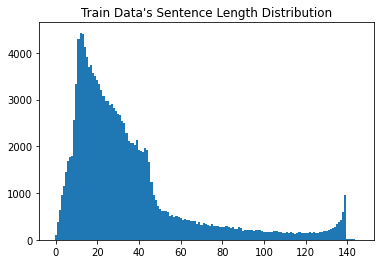

**************************************************
Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35
**************************************************


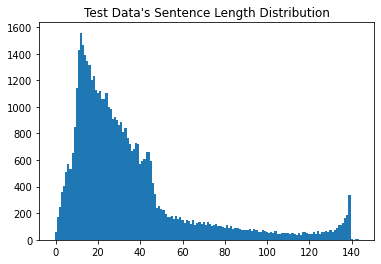

**************************************************
Data Size: 49157
문장의 최단 길이: 1
문장의 최장 길이: 144
문장의 평균 길이: 35
**************************************************


In [6]:
draw_sentence_length(train_data["document"], title="Train Data's Sentence Length Distribution")
draw_sentence_length(test_data["document"], title="Test Data's Sentence Length Distribution")

<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 분석 단계에서 확인한 결측치와 중복 데이터를 제거하여 줍니다. 또한, 단어가 최소 10개, 최대 120개로 이루어진 문장만 추출합니다.
</span>

***

#### 결측치 및 중복 데이터 제거
***
+ 분석에서 확인한 결측치와 중복 데이터를 제거 합니다.
***

In [7]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

train_data.drop_duplicates(["document"], inplace=True)
test_data.drop_duplicates(["document"], inplace=True)

<br>

#### 문장 길이 정제 하기
***
+ 최소 길이 10, 최대 길이 120으로 설정하여 데이터의 문장 길이를 정제 합니다.
***

In [8]:
#문장 길이 정제 함수=========================
def filt_length(data, min_len, max_len):
    df = train_data.copy()
    df["length"] = df["document"].apply(lambda x: len(x))
    
    df = df.loc[df["length"] >= min_len]
    df = df.loc[df["length"] <= max_len]
    
    df.drop(["length"], axis="columns", inplace=True)
    return df
#End=========================================


min_len, max_len = 10, 120

train_data = filt_length(train_data, min_len=min_len, max_len=max_len)
test_data = filt_length(test_data, min_len=min_len, max_len=max_len)

y_train = np.array(train_data["label"])
y_test = np.array(test_data["label"])

<br>

#### 문장 길이 시각화
***
+ 문장 길이 정제 후, 다시 시각화를 하여 이를 확인 합니다.


+ 학습 데이터, 테스트 데이터 모두 문장이 최소 10개, 최대 120개의 단어로 이루어 진 것을 확인할 수 있습니다.
***

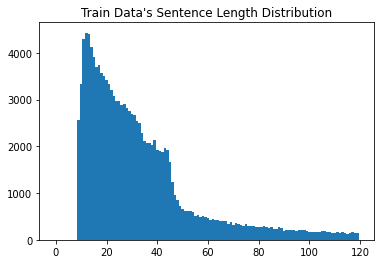

**************************************************
Data Size: 130725
문장의 최단 길이: 10
문장의 최장 길이: 120
문장의 평균 길이: 34
**************************************************


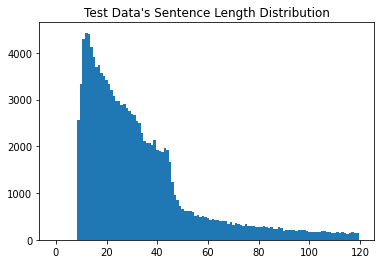

**************************************************
Data Size: 130725
문장의 최단 길이: 10
문장의 최장 길이: 120
문장의 평균 길이: 34
**************************************************


In [10]:
draw_sentence_length(train_data["document"], title="Train Data's Sentence Length Distribution")
draw_sentence_length(test_data["document"], title="Test Data's Sentence Length Distribution")

<br>

## 4. 토크나이저 별 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 토큰화 방법에 따른 성능 변화를 관찰하는 것이 목적입니다. 따라서, '공백 기반', '형태소 기반', 'SentencePiece 기반', 총 세 개의 토큰화 기법을 이용하여 성능을 비교하고자 합니다.
</span>

***

### 4.1. 공백 기반 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 공백을 기준으로 토큰화를 진행합니다. 패딩 시, 문장의 길이는 120으로 설정 합니다. 공백 기반 토큰화 결과, 총 308,447개의 토큰이 등록되었습니다.
</span>

***

#### 공백 기반 토큰화 실시
***
+ 공백을 기준으로 토큰화를 실시 합니다.
***

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

def get_split_tokenize(data):
    mecab_corpus = []
    
    for sentence in data:
        mecab_corpus.append(sentence.split())

    tokenizer.fit_on_texts(mecab_corpus)
    mecab_tensor = tokenizer.texts_to_sequences(mecab_corpus)
    mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post', maxlen=max_len)
    return mecab_tensor

<br>

#### 단어 사전 크기 확인
***
+ 공백을 기반으로 토큰화를 진행한 결과, 총 308,447개의 토큰이 등록 되었습니다.
***

In [12]:
X_train = get_split_tokenize(train_data["document"])
split_X_test = get_split_tokenize(test_data["document"])

print("*" * 50)
print("vocab size", len(tokenizer.word_index))
print("*" * 50)

**************************************************
vocab size 308446
**************************************************


<br>

#### 데이터 분할 하기
***
+ 학습 데이터와 검증 데이터를 0.2의 비율로 분할 합니다.
***

In [13]:
split_train_input, split_val_input, split_train_target, split_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

<br>

### 4.2. 형태소 기반 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 형태소를 기준으로 토큰화를 진행합니다. 패딩 시, 문장의 길이는 120으로 설정 합니다. 형태소 기반 토큰화 결과, 총 49,059개의 토큰이 등록되었습니다.
</span>

***

#### 형태소 기반 토큰화 실시
***
+ Mecab을 이용하여, 형태소를 기준으로 토큰화를 실시 합니다.
***

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
m = Mecab()

def get_mecab_tokenize(data):
    mecab_corpus = []
    
    for sentence in data:
        mecab_corpus.append(m.morphs(sentence))

    tokenizer.fit_on_texts(mecab_corpus)
    mecab_tensor = tokenizer.texts_to_sequences(mecab_corpus)
    mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post', maxlen=max_len)
    return mecab_tensor

<br>

#### 단어 사전 크기 확인
***
+ 형태소를 기반으로 토큰화를 진행한 결과, 총 49,059개의 토큰이 등록 되었습니다.
***

In [15]:
X_train = get_mecab_tokenize(train_data["document"])
mecab_X_test = get_mecab_tokenize(test_data["document"])

print("*" * 50)
print("vocab size", len(tokenizer.word_index))
print("*" * 50)

**************************************************
vocab size 49059
**************************************************


<br>

#### 데이터 분할 하기
***
+ 학습 데이터와 검증 데이터를 0.2의 비율로 분할 합니다.
***

In [16]:
mecab_train_input, mecab_val_input, mecab_train_target, mecab_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

<br>

### 4.2. SentencePiece 기반 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; SentencePiece를 기준으로 토큰화를 진행합니다. 우선, 학습 데이터를 이용하여 SentencePiece를 학습 한 후, 이를 바탕으로 토큰화를 진행합니다. 단어 사전의 크기는 8,000으로 설정하였습니다. 마찬가지로 패딩 시, 문장의 길이는 120으로 설정 합니다.
</span>

***

#### SentencePiece 학습 및 저장 하기
***
+ 학습 데이터를 이용하여 SentencePiece를 학습하고 이를 저장합니다.


+ 단어 사전의 크기는 8,000으로 설정 합니다.
***

In [17]:
vocab_size = 8000
temp_file = "./dataset/sp_tokenizer/data/korean-english-park.train.ko.temp"

with open(temp_file, 'w') as f:
    for row in list(train_data["document"]):   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

<br>

#### SentencePiece 토큰화 함수 생성
***
+ SentencePiece를 이용하여 토큰화 하는 함수를 생성 합니다.
***

In [18]:
def sp_tokenize(s, corpus):
    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./dataset/korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)

    return tensor, word_index, index_word

<br>

#### SentencePiece 토큰화 및 데이터 분할
***
+ SentencePiece를 이용하여 토큰화를 실시 합니다.


+ 학습 데이터와 검증 데이터를 0.2의 비율로 분할 합니다.
***

In [19]:
s = spm.SentencePieceProcessor()
s.Load('./dataset/korean_spm.model')

X_train, X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
sp_X_test, X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])

sp_train_input, sp_val_input, sp_train_target, sp_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

<br>

## 5. 모델 설계 및 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 각 토큰화된 데이터를 학습하기 위해 모델을 생성하고 학습합니다. 평가를 위해 모두 동일한 모델을 이용합니다. 모델은 1D Convolution 레이어를 사용하고 10 Epoch을 학습, 옵티마이저는 Adam을 이용합니다. 학습 결과, 공백 기반 토크나이저 모델의 검증 데이터에 대한 최종 손실값과 정확도는 1.344와 0.770 이며, 1Epoch 당 약 131초가 소요 되었습니다. 형태소 기반 토크나이저 모델의 검증 데이터에 대한 최종 손실값과 정확도는 0.738와 0.830 이며, 1Epoch 당 약 28초가 소요 되었습니다. SentencePiece 기반 토크나이저 모델의 검증 데이터에 대한 최종 손실값과 정확도는 0.815와 0.819 이며, 1Epoch 당 약 18초가 소요 되었습니다.
</span>

***

#### 모델 생성 및 옵티마이저 설정 함수 생성
***
+ 토크나이저 별 데이터를 학습하기 위한 모델을 생성 합니다.


+ 모델은 1D Convolution 레이어를 사용하고 옵티마이저는 'Adam'을 사용 합니다.
***

In [20]:
def get_model(vocab_size):
    model_1d = tf.keras.Sequential()
    model_1d.add(tf.keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
    model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model_1d.add(tf.keras.layers.MaxPooling1D(5))
    model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model_1d.add(tf.keras.layers.GlobalMaxPooling1D())
    model_1d.add(tf.keras.layers.Dense(8, activation='tanh'))
    model_1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    
    model_1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_1d

<br>

#### 공백 기반 토크나이저 모델 학습
***
+ 공백 기반 토큰화 데이터를 학습 합니다.


+ 검증 데이터에 대한 최종 손실값과 정확도는 1.344와 0.770 입니다.


+ 1 Epcoh 당 약 131초가 소요 됩니다.
***

In [21]:
split_model = get_model(308447)
split_model.fit(
    split_train_input, split_train_target, epochs=10, validation_data=(split_val_input, split_val_target)
)

Epoch 1/10
3269/3269 [==============================] - 137s 40ms/step - loss: 0.5511 - accuracy: 0.6817 - val_loss: 0.4259 - val_accuracy: 0.7927
Epoch 2/10
3269/3269 [==============================] - 130s 40ms/step - loss: 0.1474 - accuracy: 0.9501 - val_loss: 0.5245 - val_accuracy: 0.7810
Epoch 3/10
3269/3269 [==============================] - 130s 40ms/step - loss: 0.0238 - accuracy: 0.9931 - val_loss: 0.6729 - val_accuracy: 0.7637
Epoch 4/10
3269/3269 [==============================] - 129s 39ms/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.8571 - val_accuracy: 0.7697
Epoch 5/10
3269/3269 [==============================] - 132s 40ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 1.0297 - val_accuracy: 0.7746
Epoch 6/10
3269/3269 [==============================] - 131s 40ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.0880 - val_accuracy: 0.7684
Epoch 7/10
3269/3269 [==============================] - 130s 40ms/step - loss: 5.8658e-04 - accuracy: 0.9998 - val_los

<br>

#### 형태소 기반 토크나이저 모델 학습
***
+ 형태소 기반 토큰화 데이터를 학습 합니다.


+ 검증 데이터에 대한 최종 손실값과 정확도는 0.738와 0.830 입니다.


+ 1 Epcoh 당 약 28초가 소요 됩니다.
***

In [23]:
mecab_model = get_model(49060)
mecab_model.fit(
    mecab_train_input, mecab_train_target, epochs=10, validation_data=(mecab_val_input, mecab_val_target)
)

Epoch 1/10
3269/3269 [==============================] - 28s 8ms/step - loss: 0.1793 - accuracy: 0.9336 - val_loss: 0.3720 - val_accuracy: 0.8566
Epoch 4/10
3269/3269 [==============================] - 27s 8ms/step - loss: 0.1163 - accuracy: 0.9602 - val_loss: 0.4109 - val_accuracy: 0.8493
Epoch 5/10
3269/3269 [==============================] - 27s 8ms/step - loss: 0.0808 - accuracy: 0.9730 - val_loss: 0.4834 - val_accuracy: 0.8407
Epoch 6/10
3269/3269 [==============================] - 28s 8ms/step - loss: 0.0590 - accuracy: 0.9805 - val_loss: 0.5426 - val_accuracy: 0.8424
Epoch 7/10
3269/3269 [==============================] - 28s 8ms/step - loss: 0.0439 - accuracy: 0.9859 - val_loss: 0.6021 - val_accuracy: 0.8327
Epoch 8/10
3269/3269 [==============================] - 28s 9ms/step - loss: 0.0358 - accuracy: 0.9891 - val_loss: 0.6459 - val_accuracy: 0.8348
Epoch 9/10
3269/3269 [==============================] - 28s 8ms/step - loss: 0.0291 - accuracy: 0.9913 - val_loss: 0.7043 - val_ac

<br>

#### SentencePiece 기반 토크나이저 모델 학습
***
+ SentencePiece 기반 토큰화 데이터를 학습 합니다.


+ 검증 데이터에 대한 최종 손실값과 정확도는 0.815와 0.819 입니다.


+ 1 Epcoh 당 약 18초가 소요 됩니다.
***

In [24]:
sp_model = get_model(8000)
sp_model.fit(sp_train_input, sp_train_target, epochs=10, validation_data=(sp_val_input, sp_val_target))

Epoch 1/10
3269/3269 [==============================] - 19s 6ms/step - loss: 0.4866 - accuracy: 0.7388 - val_loss: 0.3465 - val_accuracy: 0.8493
Epoch 2/10
3269/3269 [==============================] - 18s 6ms/step - loss: 0.2864 - accuracy: 0.8811 - val_loss: 0.3382 - val_accuracy: 0.8544
Epoch 3/10
3269/3269 [==============================] - 18s 6ms/step - loss: 0.2185 - accuracy: 0.9152 - val_loss: 0.3598 - val_accuracy: 0.8484
Epoch 4/10
3269/3269 [==============================] - 18s 6ms/step - loss: 0.1533 - accuracy: 0.9450 - val_loss: 0.4142 - val_accuracy: 0.8362
Epoch 5/10
3269/3269 [==============================] - 18s 6ms/step - loss: 0.1028 - accuracy: 0.9670 - val_loss: 0.5130 - val_accuracy: 0.8352
Epoch 6/10
3269/3269 [==============================] - 18s 5ms/step - loss: 0.0706 - accuracy: 0.9781 - val_loss: 0.5764 - val_accuracy: 0.8280
Epoch 7/10
3269/3269 [==============================] - 18s 6ms/step - loss: 0.0510 - accuracy: 0.9849 - val_loss: 0.6440 - val_ac

<br>

## 6. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습이 완료된 각 모델의 테스트 데이터에 대한 성능을 확인 합니다. 그 결과, 공백 기반 토크나이저 모델의 경우, 손실값 0.269, 정확도 0.954입니다. 형태소 기반 토크나이저 모델의 경우, 손실값 0.163, 정확도 0.962입니다. SentencePiece 기반 토크나이저 모델의 경우, 손실값 0.179, 정확도 0.960입니다.
</span>

***

#### 공백 기반 토크나이저 모델
***
+ 테스트 데이터에 대한 손실값과 정확도는 0.269와 0.954 입니다.
***

In [25]:
split_model.evaluate(split_X_test, y_test)

4086/4086 [==============================] - 11s 3ms/step - loss: 0.2690 - accuracy: 0.9541


[0.2689967751502991, 0.9540944695472717]

<br>

#### 형태소 기반 토크나이저 모델
***
+ 테스트 데이터에 대한 손실값과 정확도는 0.163와 0.962 입니다.
***

In [26]:
mecab_model.evaluate(mecab_X_test, y_test)

4086/4086 [==============================] - 9s 2ms/step - loss: 0.1629 - accuracy: 0.9615


[0.16294066607952118, 0.9615069627761841]

<br>

#### 형태소 기반 토크나이저 모델
***
+ 테스트 데이터에 대한 손실값과 정확도는 0.179와 0.960 입니다.
***

In [27]:
sp_model.evaluate(sp_X_test, y_test)

4086/4086 [==============================] - 9s 2ms/step - loss: 0.1789 - accuracy: 0.9595


[0.17889101803302765, 0.9595257043838501]

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 토큰 기법에 따른 모델의 성능 비교를 위해, 네이버 영화 리뷰 문장 데이터를 사용하여, 긍, 부정 분석을 진행하였습니다. 토큰 기법은 '공백 기준', '형태소 기준', 'SentencePiece 기준'으로 구분하여 비교 합니다.
</span><br><br>
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 공백 기준 토큰화 기법의 경우, 단어사전의 크기는 308,447개로 가장 큰 편 입니다. 이는 공백 기준 토큰화가, '책이', '책을'과 같이 동일한 의미의 명사임에도 불구하고 개별적인 토큰으로 인식하기 때문에 단어사전의 크기가 커지는 것이라 할 수 있습니다. 이로인해, 1 Epoch 당 소요 시간 또한 131초로 가장 많은 시간이 소요 되었습니다. 나아가, 손실값은 0.269, 정확도는 0.954로 다른 토크나이저 모델과 비교하였을 때, 큰 차이는 아니지만 가장 좋지않은 성능을 제시하였습니다.
</span><br><br>
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 형태소 기준 토큰화 기법의 경우, Mecab을 이용하였으며, 단어사전의 크기는 49,060개로 중간에 속합니다. 공백 기준 토큰화 기법과 다르게 '형태소'를 기준으로 토큰화를 진행하기 때문에 단어사전의 크기가 작아진 것을 확인할 수 있습니다. 따라서, 1Epoch 당 소요 시간이 28초로 소폭 감소하였습니다. 손실값과 정확도는 0.163, 0.962로 가장 좋은 성능을 제시하였습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; SentencePiece 기준 토큰화 기법의 경우, 단어사전의 크기가 8,000개로 가장 작습니다. 이에, 1Epoch 당 소요 시간이 18초로 다른 모델들과 비교하였을 때, 가장 빠르게 학습이 이루어 졌습니다. 손실값과 정확도는 0.179, 0.960으로 형태소 기반 토크나이저 모델과 비교하였을 때, 큰 차이가 없는 것을 확인하였습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 결론적으로, 가장 성능이 좋은 것은 정확도 0.962의 형태소 기반으로 토큰화를 진행한 모델 입니다. 하지만, SentencePiece 기반 토큰화 기법의 경우 단어 사전의 크기가 8,000으로 가장 작고 학습 소요시간이 가장 짧음에도 불구하고 형태소 기반 토크나이저 모델의 성능과 비슷하다는 점에서 매우 효율적인 토큰화 기법이라 할 수 있겠습니다. [표 1]은 토큰화 기법에 따른 모델의 성능 분석 결과를 제시한 것입니다.
</span><br><br>


|Tokenizer|Vocab Size|Epoch / sec|Test Loss|Test Accuracy|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|**Split**|308,447|131|0.269|0.954|
|**Mecab**|49,060|28|**0.163**|**0.962**|
|**SentencePiece**|8,000|**18**|0.179|0.960|

[표 1] 토큰화 기법에 따른 모델 성능

***

#### 형상관리 기록
***
+ v1_1: 초기 예제


+ v2_1: 제출 예제 진행
***